In [1]:
import numpy as np

import tensorflow
import sciann as sn

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io

import pandas as pd

import h5py

---------------------- SCIANN 0.6.0.4 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 



In [2]:
path = "NoCracK/config_file/Event0000/output.h5"

hf = h5py.File(path, 'r')

In [3]:
hf.keys()

<KeysViewHDF5 ['connectivity_ACOUSTIC', 'coordinates_ACOUSTIC', 'partitioning', 'volume']>

In [4]:
selected_ts = 70

loc = hf['coordinates_ACOUSTIC'][:].reshape(hf['coordinates_ACOUSTIC'][:].shape[0]*hf['coordinates_ACOUSTIC'][:].shape[1],2)

df = pd.DataFrame(columns={'X','Y'})
df['X'] = loc[:,0]
df['Y'] = loc[:,1]
df['X'] = np.round(df['X'],5)
df['Y'] = np.round(df['Y'],5)

values = hf['volume']['phi'][selected_ts,:,:,:25].reshape(2500*25)

df['PHI'] = values

df_clean = df.pivot_table(values='PHI',index='Y',columns='X')
df_clean.sort_index(axis=0,ascending=False,inplace=True)

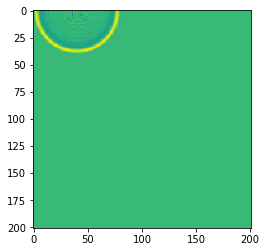

In [5]:
plt.imshow(df_clean.values)

In [6]:
x = sn.Variable('x')
y = sn.Variable('y')
t = sn.Variable('t')

p = sn.Functional('p', [x, y, t], 8*[20], 'tanh')

In [7]:
vp = 1400
rho = 1200

c = np.sqrt(vp/rho)

In [8]:
p_xx = sn.diff(p, x, order=2)
p_yy = sn.diff(p, y, order=2)
p_tt = sn.diff(p, t, order=2)

L1 = p_xx + p_yy - 1/(c**2)*p_tt

In [9]:
# Data : 
x_data, y_data, t_data = np.meshgrid(
    np.linspace(0, 0.25, 101),
    np.linspace(0, 0.25, 101),
    np.linspace(0, 1e-4, 101)
    )

In [10]:
# Ricker source time function
def Ricker(t,f):
    """
    t = time interval
    f = center frequency
    """
    t0 = 2./f
    ricker_wavelet = (1 - 2 * (np.pi ** 2) * (f ** 2) * ((t - t0) ** 2))*np.exp(-(np.pi ** 2) * (f ** 2) * ((t - t0) ** 2))
    return ricker_wavelet

In [11]:
# Boxcar source time funciton
def Boxcar(t,f):
    t0 = 2./f
    boxcar_wavelet  = -8. * (t - t0) * f * (np.exp(-1.0 * (4*f) ** 2 * (t - t0) ** 2))
    return boxcar_wavelet

Text(0.5, 1.0, 'Ricker')

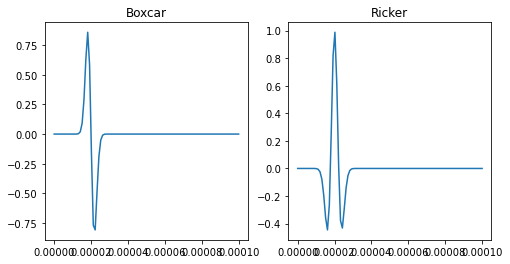

In [19]:
f = 1e5

t_in = np.linspace(0,1e-4,100)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(t_in,Boxcar(t_in,f))
ax[0].set_title('Boxcar')
ax[1].plot(t_in,Ricker(t_in,f))
ax[1].set_title('Ricker')

In [20]:
from sciann.utils.math import sign, exp
from numpy import pi

In [21]:
TOL = 0.001

# Initial conditions for p :
# p(t=0,x,y) = 0
C1 = (1-sign(t - TOL)) * (p) 

# Boundary conditions for p at the source location
# p(t,x=x_s,y=y_s) = source
t0 = 2./f
xs = 0.125
ys = 0.125

C2 = (1-sign(x - (xs+TOL) + y - (ys+TOL) )) * (p - (1 - 2 * (pi ** 2) * (f ** 2) * ((t - t0) ** 2))*exp(-(pi ** 2) * (f ** 2) * ((t - t0) ** 2)))

In [22]:
# Define the optimization model (set of inputs and constraints)
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[L1, C1, C2],
    loss_func="mse"
)

In [23]:
h = model.train([x_data, y_data, t_data], 3*['zero'], learning_rate=0.002,batch_size=1024, epochs=200, verbose=1)

Train on 1030301 samples
Epoch 1/200
1030301/1030301 [==============================] - 24s 23us/sample - loss: 0.0601 - sub_loss: 1.3083e-05 - mul_2_loss: 1.7093e-04 - mul_6_loss: 0.0599
Epoch 2/200
1030301/1030301 [==============================] - 24s 23us/sample - loss: 0.0599 - sub_loss: 5.0151e-08 - mul_2_loss: 3.4356e-05 - mul_6_loss: 0.0598
Epoch 3/200
1030301/1030301 [==============================] - 23s 23us/sample - loss: 0.0599 - sub_loss: 2.8598e-08 - mul_2_loss: 3.0920e-05 - mul_6_loss: 0.0598
Epoch 4/200
1030301/1030301 [==============================] - 23s 23us/sample - loss: 0.0599 - sub_loss: 6.5588e-08 - mul_2_loss: 2.7223e-05 - mul_6_loss: 0.0599
Epoch 5/200
1030301/1030301 [==============================] - 24s 23us/sample - loss: 0.0599 - sub_loss: 9.0197e-08 - mul_2_loss: 2.3908e-05 - mul_6_loss: 0.0599
Epoch 6/200
1030301/1030301 [==============================] - 24s 24us/sample - loss: 0.0599 - sub_loss: 4.4771e-08 - mul_2_loss: 2.4359e-05 - mul_6_loss: 0.05

In [3]:
x_test, y_test, t_test = np.meshgrid(
    np.linspace(0, 0.25, 101),
    np.linspace(0, 0.25, 101),
    np.linspace(0, 1e-4, 101)
)
p_pred = p.eval(model, [x_test, y_test, t_test])

NameError: name 'p' is not defined

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4),sharey=True)

cbar = plt.colorbar(ax[0].imshow(p_pred[:,:,99],extent=[-1, 1, -1, 1]),ax=ax[0])
cbar.set_label('Velocity (m/s)')
ax[0].set_xlabel('x (m)', fontsize=14)
ax[0].set_ylabel('y (m)', fontsize=14)

ax[0].tick_params(labelsize=10)
ax[0].set_title('Initial conditions for u', fontsize=14)

cbar = plt.colorbar(ax[1].imshow(p_pred[:,:,0],extent=[-1, 1, -1, 1]),ax=ax[1])
cbar.set_label('Velocity (m/s)')
ax[1].set_xlabel('x (m)', fontsize=14)

ax[1].tick_params(labelsize=10)
ax[1].set_title('Initial conditions for v', fontsize=14)